In [1]:
# import libs
import torch
from torch import nn, optim
from torch.optim import Optimizer
from torch.nn import functional as F

import torchvision
import torchvision.datasets as datasets
from pytorch_model_summary import summary

import math
import time
from tqdm import tqdm
from collections import defaultdict

## 1. Model and Optimizer Defining
We define here the new optimizers and the model we are using

In [ ]:
# Optimizer Combinations

class AdamSGDWeighted(Optimizer):
    r"""Implements Adam, SGD and DFE mix algorithm.
    """

    def __init__(self,
                 params, lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,
                 adam_w=0.3, sgd_w=0.3, transform='linear'):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(
            lr=lr, weight_decay=weight_decay,
            betas=betas, eps=eps, amsgrad=amsgrad,
            momentum=momentum, dampening=dampening, nesterov=nesterov,
            adam_w=adam_w, sgd_w=sgd_w
        )
        super(AdamSGDWeighted, self).__init__(params, defaults)
        self.eps = eps
        self.transform = transform
    def __setstate__(self, state):
        super(AdamSGDWeighted, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('AdamSGDDFEWeighted does not support sparse gradients')

                d_p_adam, step_size = self.adam_step(grad, group, p)

                d_p_sgd = self.sgd_step(grad, group, p)
                
                if self.transform == 'polynomial':
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * (d_p_adam**2 + d_p_adam) 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )

                elif self.transform == 'linear':
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * d_p_adam 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )

                elif self.transform == 'correction':
                    
                    if torch.sum(d_p_sgd * d_p_adam) > 0: 
                        megred_d_p = group['sgd_w'] * d_p_sgd 
                        merged_lr = group['sgd_w'] * group['lr'] 
                    else:
                        megred_d_p = group['adam_w'] * d_p_adam 
                        merged_lr = group['adam_w'] * step_size 

                    merged_lr = group['sgd_w'] * group['lr'] + group['adam_w'] * step_size 

                elif self.transform == 'normalized':
                    megred_d_p = group['sgd_w'] * step_size * d_p_sgd/torch.norm(d_p_adam)
                    merged_lr = group['sgd_w'] * group['lr']

                elif self.transform == 'vector_combine':
                    d_p_sgd[d_p_sgd.shape[0]//2:] = 0
                    d_p_adam[:d_p_sgd.shape[0]//2] = 0
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * d_p_adam 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )/2

                p.add_(megred_d_p, alpha=-merged_lr)

        return loss

    def adam_step(self, grad, group, p):
        amsgrad = group['amsgrad']
        state = self.state[p]
        # State initialization
        if len(state) == 0:
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            # Exponential moving average of squared gradient values
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            if amsgrad:
                # Maintains max of all exp. moving avg. of sq. grad. values
                state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        if amsgrad:
            max_exp_avg_sq = state['max_exp_avg_sq']
        beta1, beta2 = group['betas']
        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']
        if group['weight_decay'] != 0:
            grad = grad.add(p, alpha=group['weight_decay'])
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        step_size = group['lr'] / bias_correction1

        d_p = exp_avg / denom
        return d_p, step_size

    def sgd_step(self, grad, group, p):
        d_p = grad
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']
        if weight_decay != 0:
            d_p = d_p.add(p, alpha=weight_decay)
        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        return d_p
    

In [ ]:
# Model we use
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 312),
            nn.ReLU(),
            nn.Linear(312, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = self.base(x)
        x = self.fc3(x)
        return x

In [ ]:
# Training script
def train(model,trainloader,testloader, nb_epochs = 100, eta = 1e-3, adam_w=0.5, sgd_w=0.5, transform='linear', mix='Mix'):
    
    criterion = nn.CrossEntropyLoss()
    if mix == 'Mix':
      optimizer = AdamSGDWeighted(model.parameters(), lr=eta, momentum=0, adam_w=adam_w, sgd_w=sgd_w, transform=transform)
    elif mix == 'Adam':
      optimizer = optim.Adam(cnn.parameters(), lr=eta)
    elif mix == 'SGD':
      optimizer = optim.SGD(cnn.parameters(), lr=eta, momentum=0.9)

    acc_val = []
    loss_train = []
    loss_val = []

    for e in range(nb_epochs):
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            # inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)

            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            if mix == 'Mix': 
              optimizer.step(lambda: float(loss))
            else:
              optimizer.step()

            # print statistics
            running_loss += loss.item()
            rep = 2000
            if i % rep == 1999:    # print every 2000 mini-batches
                loss_train.append(running_loss/rep)
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i + 1, running_loss / rep))
                running_loss = 0.0
                correct = 0
                total = 0
                
                # since we're not training, we don't need to calculate the gradients for our outputs
                with torch.no_grad():
                    rloss_val = 0
                    for data in testloader:
                        images, labels = data
                        # images, labels = images.cuda(), labels.cuda()

                        outputs = model(images)
                        rloss = criterion(outputs, labels)
                        rloss_val += rloss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('Accuracy of the network on the 10000 test images: %d %%' % (
                    100 * correct / total))
                acc_val.append(correct / total)
                loss_val.append(rloss_val/ total)
    return acc_val, loss_val

## Loading CIFAR10

In [ ]:
# Loading in DataLoader Cifar10
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Methods Testing

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

runs = 10

### Baseline

In [11]:
# SGD
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc = []
histories_loss = []

lr = 1e-3
alpha = 0.6

for i in range(runs):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, mix='SGD')
    histories_acc.append(history_acc)
    histories_loss.append(history_loss)

In [12]:
# Adam
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc0 = []
histories_loss0 = []

lr = 1e-3
alpha = 0.6

for i in range(runs):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, mix='Adam')
    histories_acc0.append(history_acc)
    histories_loss0.append(history_loss)

### Linear combination

In [10]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    cnn = CNN().to(device)

    history = train(cnn, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='linear')
    
    histories.append(history)

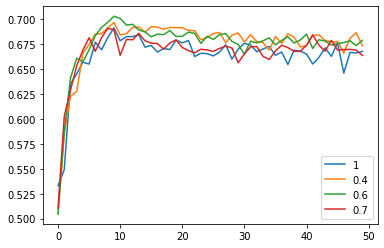

In [ ]:
fig, ax = plt.subplots(1,1)

histories_acc = [hist[0] for hist in histories]
ax.plot(range(len(histories_acc[0])),histories_acc[0], label='gamma'+str(alphas[0]))
ax.plot(range(len(histories_acc[1])),histories_acc[1], label='gamma'+str(alphas[1]))
ax.plot(range(len(histories_acc[2])),histories_acc[2], label='gamma'+str(alphas[2]))
ax.plot(range(len(histories_acc[3])),histories_acc[3], label='gamma'+str(alphas[3]))
plt.legend()

In [9]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc1 = []
histories_loss1 = []

lr = 1e-3
alpha = 0.6

for i in range(runs):

    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='linear')
    histories_acc1.append(history_acc)
    histories_loss1.append(history_loss)

### Polynomial Combination

In [8]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    cnn = CNN().to(device)

    history = train(cnn, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='polynomial')
    
    histories.append(history)

In [13]:
fig, ax = plt.subplots(1,1)

histories_acc = [hist[0] for hist in histories]
ax.plot(range(len(histories_acc[0])),histories_acc[0], label='gamma'+str(alphas[0]))
ax.plot(range(len(histories_acc[1])),histories_acc[1], label='gamma'+str(alphas[1]))
ax.plot(range(len(histories_acc[2])),histories_acc[2], label='gamma'+str(alphas[2]))
ax.plot(range(len(histories_acc[3])),histories_acc[3], label='gamma'+str(alphas[3]))
plt.legend()

### Correction

In [2]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    cnn = CNN().to(device)

    history = train(cnn, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='correction')
    
    histories.append(history)

In [ ]:
fig, ax = plt.subplots(1,1)

histories_acc = [hist[0] for hist in histories]
ax.plot(range(len(histories_acc[0])),histories_acc[0], label='gamma'+str(alphas[0]))
ax.plot(range(len(histories_acc[1])),histories_acc[1], label='gamma'+str(alphas[1]))
ax.plot(range(len(histories_acc[2])),histories_acc[2], label='gamma'+str(alphas[2]))
ax.plot(range(len(histories_acc[3])),histories_acc[3], label='gamma'+str(alphas[3]))
plt.legend()

In [3]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc2 = []
histories_loss2 = []

lr = 1e-3
alpha = 0.6

for i in tqdm(range(runs)):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='correction')
    histories_acc2.append(history_acc)
    histories_loss2.append(history_loss)

### Normalization

In [4]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    cnn = CNN().to(device)

    history = train(cnn, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='normalized')
    
    histories.append(history)

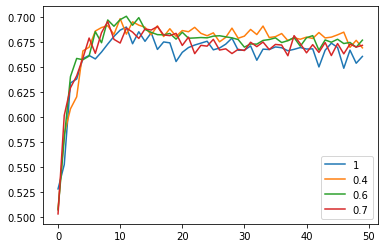

In [ ]:
fig, ax = plt.subplots(1,1)

histories_acc = [hist[0] for hist in histories]
ax.plot(range(len(histories_acc[0])),histories_acc[0], label='gamma'+str(alphas[0]))
ax.plot(range(len(histories_acc[1])),histories_acc[1], label='gamma'+str(alphas[1]))
ax.plot(range(len(histories_acc[2])),histories_acc[2], label='gamma'+str(alphas[2]))
ax.plot(range(len(histories_acc[3])),histories_acc[3], label='gamma'+str(alphas[3]))
plt.legend()

In [5]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc3 = []
histories_loss3 = []

lr = 1e-3
alpha = 0.6

for i in range(runs):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='normalized')
    histories_acc3.append(history_acc)
    histories_loss3.append(history_loss)

### Vector Combination

In [6]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    cnn = CNN().to(device)

    history = train(cnn, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='vector_combine')
    
    histories.append(history)

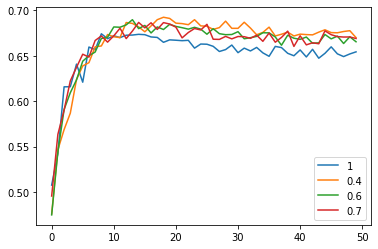

In [ ]:
fig, ax = plt.subplots(1,1)

histories_acc = [hist[0] for hist in histories]
ax.plot(range(len(histories_acc[0])),histories_acc[0], label='gamma'+str(alphas[0]))
ax.plot(range(len(histories_acc[1])),histories_acc[1], label='gamma'+str(alphas[1]))
ax.plot(range(len(histories_acc[2])),histories_acc[2], label='gamma'+str(alphas[2]))
ax.plot(range(len(histories_acc[3])),histories_acc[3], label='gamma'+str(alphas[3]))
plt.legend()

In [7]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc4 = []
histories_loss4 = []

lr = 1e-3
alpha = 0.6

for i in range(runs):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='vector_combine')
    histories_acc4.append(history_acc)
    histories_loss4.append(history_loss)

## Evaluation Plots
Using the 10 runs per variants we have compute prior

In [ ]:
import os

Logs = os.listdir('drive/MyDrive/dfw/Logs')
logs_acc = [log for log in Logs if log.endswith('acc.pkl')]
logs_loss = [log for log in Logs if log.endswith('loss.pkl')]

methods = ['sgd', 'adam', 'linear', 'normalization', 'vector', 'correction']

Acc = {}
Loss = {}
for log_acc in logs_acc:
    with open('./drive/MyDrive/dfw/Logs/'+log_acc, 'rb') as fp:
        banana = pickle.load(fp)
        log_acc = log_acc.split('_')[0]
        Acc[log_acc] = banana

for log_loss in logs_loss:
    with open('./drive/MyDrive/dfw/Logs/'+log_loss, 'rb') as fp:
        log_loss = log_loss.split('_')[0]
        banana = pickle.load(fp)
        Loss[log_loss] = banana

L_loss = np.asarray([Loss[method] for method in methods],dtype=float)
L_acc = np.asarray([Acc[method] for method in methods],dtype=float)

In [ ]:
logs_acc, logs_loss

(['linear_acc.pkl',
  'sgd_acc.pkl',
  'adam_acc.pkl',
  'vector_acc.pkl',
  'correction_acc.pkl',
  'normalization_acc.pkl'],
 ['linear_loss.pkl',
  'adam_loss.pkl',
  'sgd_loss.pkl',
  'correction_loss.pkl',
  'normalization_loss.pkl',
  'vector_loss.pkl'])

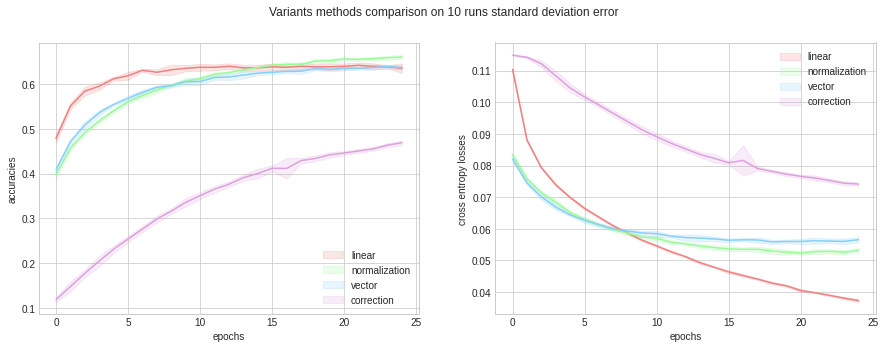

In [ ]:
plt.style.use('seaborn-whitegrid')

means = np.nanmean(L_acc, axis=1)
stds = np.nanstd(L_acc, axis=1)

means2 = np.nanmean(L_loss, axis=1)
stds2 = np.nanstd(L_loss, axis=1)

colors = ['lightcoral','palegreen','lightskyblue','plum']

fig, ax = plt.subplots(1,2, figsize=(15,5))

# plot accuracies and losses one
for i in range(4):
  ax[0].plot(range(25), means[i+2], '-', color=colors[i])
  ax[0].fill_between(range(25), means[i+2] - stds[i+2], means[i+2] + stds[i+2],
                  color=colors[i], alpha=0.2, label=methods[i+2])
  
  ax[1].plot(range(25), means2[i+2], '-', color=colors[i])
  ax[1].fill_between(range(25), means2[i+2] - stds2[i+2], means2[i+2] + stds2[i+2],
                  color=colors[i], alpha=0.2, label=methods[i+2])

ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracies')

ax[1].set_xlabel('epochs')
ax[1].set_ylabel('cross entropy losses')

ax[0].legend()
ax[1].legend()
plt.suptitle('Variants methods comparison on 10 runs standard deviation error')
plt.show()

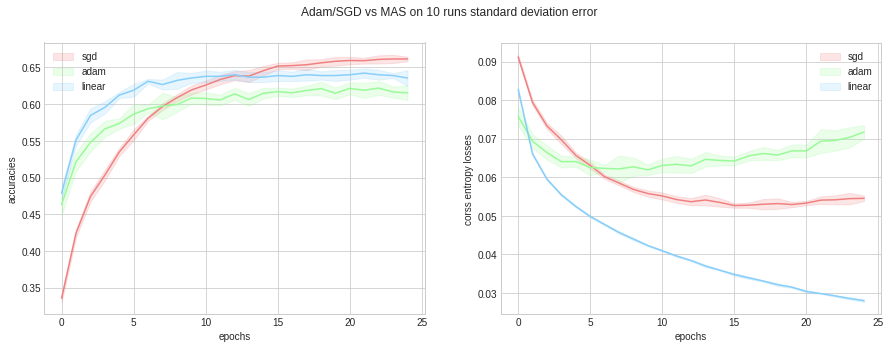

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# plot accuracies and losses one
for i in range(3):
  ax[0].plot(range(25), means[i], '-', color=colors[i])
  ax[0].fill_between(range(25), means[i] - stds[i], means[i] + stds[i],
                  color=colors[i], alpha=0.2, label=methods[i])
  
  ax[1].plot(range(25), means2[i], '-', color=colors[i])
  ax[1].fill_between(range(25), means2[i] - stds2[i], means2[i] + stds2[i],
                  color=colors[i], alpha=0.2, label=methods[i])

ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracies')

ax[1].set_xlabel('epochs')
ax[1].set_ylabel('corss entropy losses')

ax[0].legend()
ax[1].legend()
plt.suptitle('Adam/SGD vs MAS on 10 runs standard deviation error')
plt.show()